In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
mnist = fetch_openml(data_id=554) # https://www.openml.org/d/554

In [6]:
batch_size = 128
dataloader = DataLoader(torch.Tensor(mnist.data/255), batch_size=batch_size)

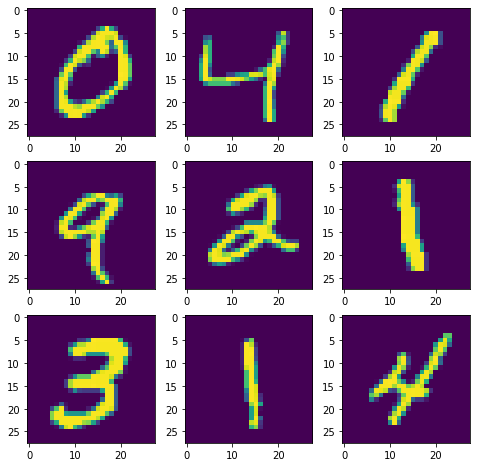

In [7]:
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3

for i in range(1, columns*rows +1):
  img = mnist.data[i].reshape(28,28)
  fig.add_subplot(rows, columns, i)
  plt.imshow(img)

plt.show()

In [8]:
class Generator(nn.Module):
  def __init__(self, z_dim, hidden_dim, img_dim):
    super().__init__()
    self.gen = nn.Sequential(
        self.make_G_block(z_dim, hidden_dim),
        self.make_G_block(hidden_dim, hidden_dim),
        nn.Linear(hidden_dim, img_dim),
        nn.Tanh()
    )

  def forward(self, x):
    return self.gen(x)

  def make_G_block(self, input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU()
    )

In [9]:
class Discriminator(nn.Module):
  def __init__(self, img_dim, hidden_dim):
    super().__init__()
    self.disc = nn.Sequential(
        self.make_D_block(img_dim, hidden_dim),
        self.make_D_block(hidden_dim, hidden_dim),
        nn.Linear(hidden_dim, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.disc(x)

  def make_D_block(self, input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2)
    )

In [10]:
img_size = 784
hidden_size = 256
latent_size = 64

G = Generator(latent_size, hidden_size, img_size).to(device)
D = Discriminator(img_size, hidden_size).to(device)

In [11]:
criterion = nn.BCELoss()
G_optim = optim.Adam(G.parameters(), lr=0.0002)
D_optim = optim.Adam(D.parameters(), lr=0.0002)

In [14]:
def get_D_loss(G, D, criterion, real, latent_size, device):
  z = torch.randn(real.size(0), latent_size, device=device)
  fake = G(z)

  D_real_pred = D(real)
  D_fake_pred = D(fake.detach())
  D_loss_fake = criterion(D_fake_pred, torch.zeros_like(D_fake_pred))
  D_loss_real = criterion(D_real_pred, torch.ones_like(D_real_pred))
  D_loss = (D_loss_fake + D_loss_real) / 2

  return D_loss


def get_G_loss(G, D, criterion, batch_size, latent_size, device):
  z = torch.randn(batch_size, latent_size, device=device)
  fake = G(z)
  D_fake_pred = D(fake)
  G_loss = criterion(D_fake_pred, torch.ones_like(D_fake_pred))
  
  return G_loss

Epoch 10
Generator loss: 87.21
Discriminator loss: 0.25



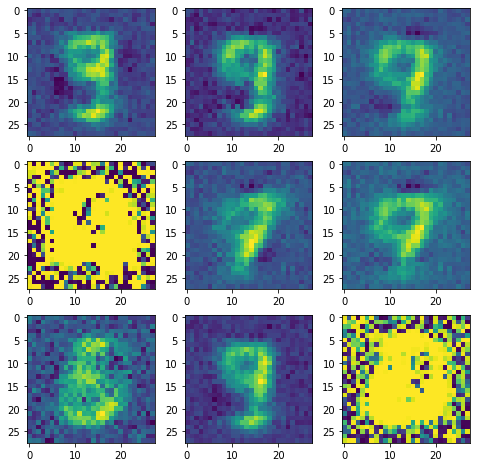

Epoch 20
Generator loss: 62.82
Discriminator loss: 0.20



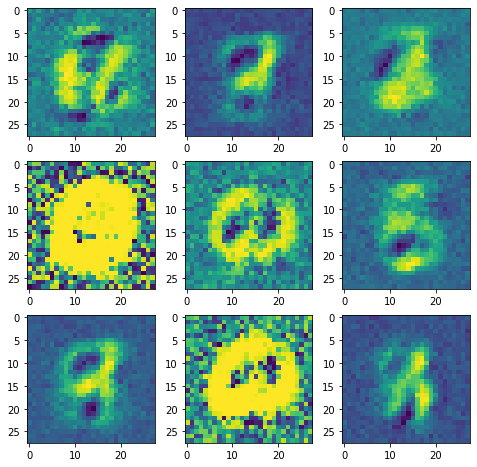

Epoch 30
Generator loss: 29.88
Discriminator loss: 0.20



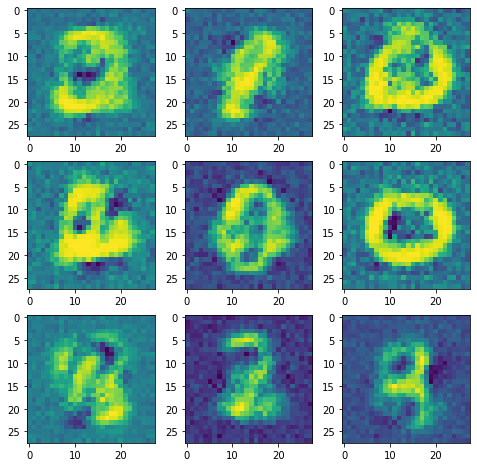

Epoch 40
Generator loss: 31.82
Discriminator loss: 0.19



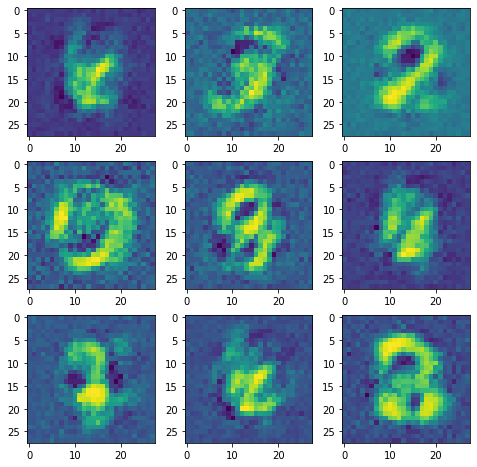

Epoch 50
Generator loss: 30.83
Discriminator loss: 0.22



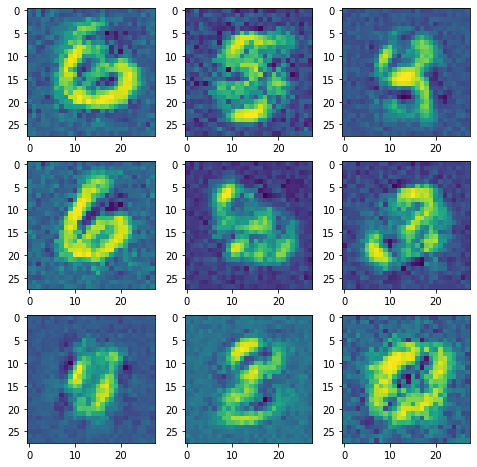

Epoch 60
Generator loss: 29.38
Discriminator loss: 0.23



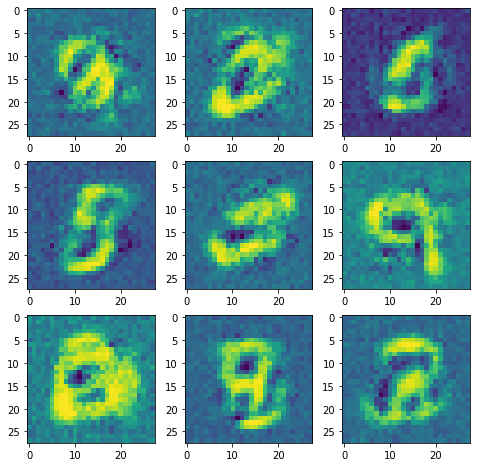

Epoch 70
Generator loss: 28.29
Discriminator loss: 0.27



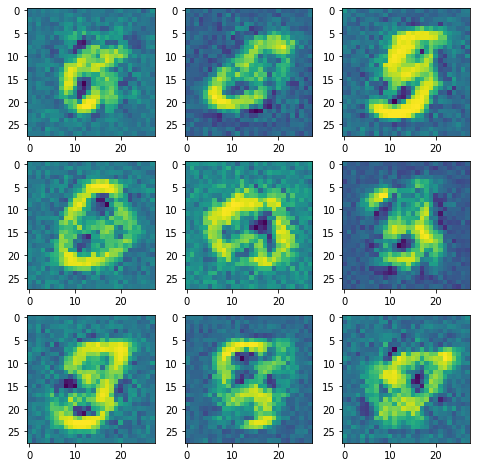

Epoch 80
Generator loss: 26.99
Discriminator loss: 0.30



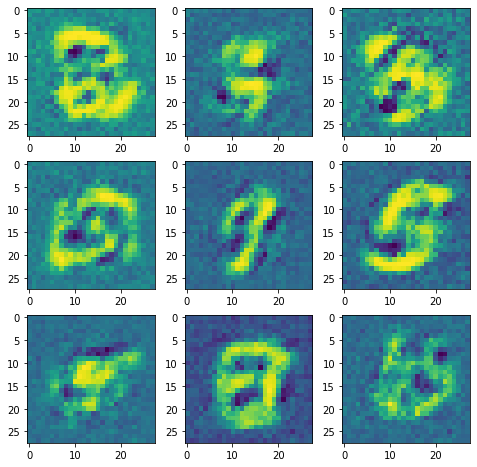

Epoch 90
Generator loss: 24.68
Discriminator loss: 0.35



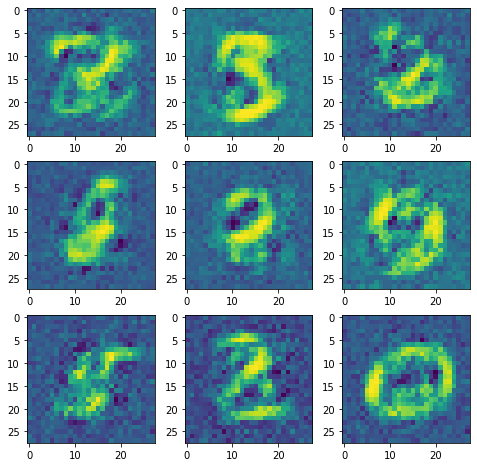

Epoch 100
Generator loss: 24.66
Discriminator loss: 0.36



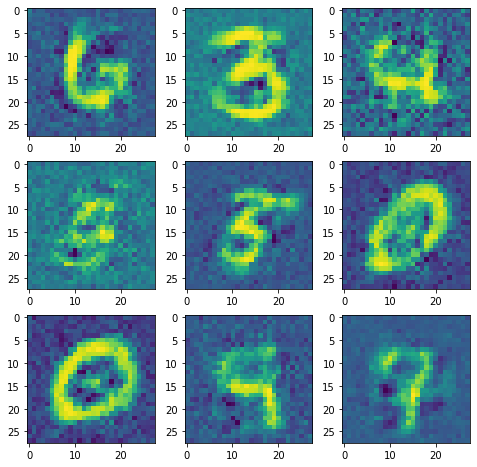

In [15]:
from tqdm.notebook import tqdm

epochs = 100
show_every = 10

D_total_loss = []
G_total_loss = []

for epoch in tqdm(range(epochs)):
  D_batch_loss = 0
  G_batch_loss = 0

  for real in dataloader:
    real = real.to(device)

    # Discriminator
    D_optim.zero_grad()

    D_loss = get_D_loss(G, D, criterion, real, latent_size, device)
    D_batch_loss += D_loss

    D_loss.backward()
    D_optim.step()

    # Generator
    G_optim.zero_grad()

    G_loss = get_G_loss(G, D, criterion, batch_size, latent_size, device)
    G_batch_loss += G_loss

    G_loss.backward()
    G_optim.step()
  
  D_batch_loss = D_batch_loss / batch_size
  D_total_loss.append(D_batch_loss)
  G_batch_loss = G_batch_loss / batch_size
  G_total_loss.append(G_batch_loss)

  if (epoch+1) % show_every == 0:
    print(f'Epoch {epoch+1}')
    print(f'Generator loss: {G_batch_loss:.2f}')
    print(f'Discriminator loss: {D_batch_loss:.2f}')
    print()

    fig=plt.figure(figsize=(8, 8))
    columns = 3
    rows = 3

    noise = torch.randn(columns*rows, latent_size).to(device)
    pred = G(noise)
    pred = pred.cpu().detach().numpy()

    for i in range(1, columns*rows +1):
      img = pred[i-1].reshape(28,28)
      fig.add_subplot(rows, columns, i)
      plt.imshow(img)

    plt.show()